In [1]:
!pip install nilearn pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 66.3 MB/s eta 0:00:00


In [2]:
import cv2
import pdb
import os
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import ipywidgets as widgets
import scipy.signal, scipy.misc
import plotly.graph_objects as go
import random
import base64
import io

from ipywidgets import interact, IntSlider, FloatSlider
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting, datasets, image, regions
from nilearn.connectome import ConnectivityMeasure
from nilearn.decoding import Decoder
from nilearn.image import mean_img, index_img
from nilearn.datasets import MNI152_FILE_PATH, load_mni152_template
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_glass_brain, view_img_on_surf, plot_epi, show, plot_roi, view_img
from nibabel.testing import data_path
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.model_selection import LeaveOneGroupOut
from skimage import data
from skimage.color import rgb2gray
from math import *
from pathlib import Path
from PIL import Image

import torch
import torch.fft as fft
import torch.nn.functional as F
import math
from torch import nn
from torch.utils.data import DataLoader
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from scipy.ndimage import gaussian_filter
from google.colab import drive

/tmp/ipython-input-2839700477.py:10: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.signal, scipy.misc


In [3]:
drive.mount('/content/drive')
!mkdir -p /content/data
!cp -r /content/drive/MyDrive/mri_data/train/ /content/data/train
!cp -r /content/drive/MyDrive/mri_data/test/ /content/data/test

Mounted at /content/drive


In [4]:
train_data_path = "/content/data/train"
test_data_path = "/content/data/test"
import os

train_data_pair_paths = []

for i in range(18):
    lf = os.path.join(
        train_data_path,
        "low_field",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    hf = os.path.join(
        train_data_path,
        "high_field",
        f"sample_{i+1:03d}_highfield.nii"
    )

    train_data_pair_paths.append([lf, hf])

# for lf, hf in train_data_pair_paths:
#     print(os.path.exists(lf), os.path.exists(hf))

In [5]:
def ensure_3d(volume):
    if volume.ndim == 4:
        return volume[..., 0]
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D or 4D volume, got {volume.shape}")
    return volume


def plot_fractional_slices(volume, title, fractions=(0.25, 0.5, 0.75), cmap="gray"):
    """
    Plot axial slices at given fractional depths along Z-axis.
    """
    volume = ensure_3d(volume)
    z_dim = volume.shape[2]

    slice_indices = [int(f * (z_dim - 1)) for f in fractions]

    fig, axes = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 5))

    if len(slice_indices) == 1:
        axes = [axes]

    for ax, z in zip(axes, slice_indices):
        ax.imshow(volume[:, :, z], cmap=cmap)
        ax.set_title(f"{title}\nSlice z={z}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()



In [6]:
def plot_fractional_slices_pair(low, high, brain_id, fractions=(0.1, 0.25, 0.5, 0.66, 0.75)):
    low = ensure_3d(low)
    high = ensure_3d(high)

    zl = low.shape[2]
    zh = high.shape[2]

    low_idxs  = [int(f * (zl - 1)) for f in fractions]
    high_idxs = [int(f * (zh - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, (lz, hz) in enumerate(zip(low_idxs, high_idxs)):
        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(high[:, :, hz], cmap="gray")
        axes[1, j].set_title(f"High-field\nz={hz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id:02d}", fontsize=16)
    plt.tight_layout()
    plt.show()


selected_indices = random.sample(range(len(train_data_pair_paths)), 3)

print("Selected brains:", [i + 1 for i in selected_indices])

for i in selected_indices:
    low_path, high_path = train_data_pair_paths[i]

    img_low = nib.load(low_path)
    img_high = nib.load(high_path)

    plot_fractional_slices_pair(
        img_low.get_fdata(),
        img_high.get_fdata(),
        brain_id=i + 1
    )

Output hidden; open in https://colab.research.google.com to view.

In [7]:
def lowpass_mask(shape, cutoff):
    H, W = shape
    y = torch.linspace(-0.5, 0.5, H)
    x = torch.linspace(-0.5, 0.5, W)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= cutoff).float()

def add_rician_noise(x, sigma):
    noise_real = torch.randn_like(x) * sigma
    noise_imag = torch.randn_like(x) * sigma
    return torch.sqrt((x + noise_real)**2 + noise_imag**2)

def degrade(x_hr, scale=2, cutoff=0.25, noise_sigma=0.01):
    # FFT
    X = fft.fftshift(fft.fft2(x_hr))

    # Low-pass filter
    mask = lowpass_mask(X.shape[-2:], cutoff).to(X.device)
    X = X * mask

    # Back to image
    x_lp = fft.ifft2(fft.ifftshift(X)).real

    # Downsample
    x_lr = F.avg_pool2d(x_lp, kernel_size=scale)

    # Add Rician noise
    x_lr = add_rician_noise(x_lr, noise_sigma)

    return x_lr

def safe_residual(residual, cutoff):
    R = fft.fftshift(fft.fft2(residual))
    mask = lowpass_mask(R.shape[-2:], cutoff).to(R.device)
    R = R * mask
    return fft.ifft2(fft.ifftshift(R)).real

def reconstruct(model, y_lr, scale=2, cutoff=0.25):
    y_up = F.interpolate(y_lr, scale_factor=scale, mode='bilinear', align_corners=False)
    r = model(y_up)
    r_safe = safe_residual(r, cutoff)
    return y_up + r_safe

def tv_loss(x):
    dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
    dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
    return dx.mean() + dy.mean()

def physics_loss(x_hat, y_lr, lam=0.01):
    y_hat = degrade(x_hat)
    dc = F.mse_loss(y_hat, y_lr)
    tv = tv_loss(x_hat)
    return dc + lam * tv



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# =========================
# Utility: Load + Normalize NIfTI
# =========================
def load_nii(path):
    nii = nib.load(path)
    data = nii.get_fdata().astype(np.float32)
    return data

def normalize_mri(vol):
    p1, p99 = np.percentile(vol, (1, 99))
    vol = np.clip(vol, p1, p99)
    vol = (vol - p1) / (p99 - p1 + 1e-6)
    return vol.astype(np.float32)   # ← critical line

# =========================
# Slice index mapping (40 → 200)
# =========================
def map_lr_to_hr_slice(k, lr_slices=40, hr_slices=200):
    return int((k / lr_slices) * hr_slices)

# =========================
# Dataset (2D axial slices)
# =========================
class MRINiftiSliceDataset(DataLoader):
    def __init__(self, pair_paths):
        """
        pair_paths: list of [low_field_path, high_field_path]
        """
        self.samples = []

        for lf_path, hf_path in pair_paths:
            lr_vol = normalize_mri(load_nii(lf_path))
            hr_vol = normalize_mri(load_nii(hf_path))

            assert lr_vol.ndim == 3
            assert hr_vol.ndim == 3

            for k in range(lr_vol.shape[2]):
                z_hr = map_lr_to_hr_slice(k)
                self.samples.append((
                    lr_vol[:, :, k],
                    hr_vol[:, :, z_hr]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        y_lr, x_hr = self.samples[idx]
        return (
            torch.from_numpy(y_lr).unsqueeze(0),  # [1, H, W]
            torch.from_numpy(x_hr).unsqueeze(0)
        )

# =========================
# Frequency Utilities
# =========================
def lowpass_mask(shape, cutoff):
    H, W = shape
    y = torch.linspace(-0.5, 0.5, H, device=device)
    x = torch.linspace(-0.5, 0.5, W, device=device)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= cutoff).float()

def safe_lowpass(x, cutoff):
    X = fft.fftshift(fft.fft2(x))
    mask = lowpass_mask(X.shape[-2:], cutoff)
    X = X * mask
    return fft.ifft2(fft.ifftshift(X)).real

# =========================
# Physics Degradation (x–y only)
# =========================
def degrade_xy(x_hat, y_lr, cutoff=0.35, noise_sigma=0.01):
    # Low-pass in Fourier domain
    X = fft.fftshift(fft.fft2(x_hat))
    mask = lowpass_mask(X.shape[-2:], cutoff)
    X = X * mask
    x_lp = fft.ifft2(fft.ifftshift(X)).real

    # Downsample EXACTLY to low-field shape
    x_lr = F.interpolate(
        x_lp,
        size=y_lr.shape[-2:],
        mode="bilinear",
        align_corners=False
    )

    # Rician noise
    n1 = torch.randn_like(x_lr) * noise_sigma
    n2 = torch.randn_like(x_lr) * noise_sigma
    return torch.sqrt((x_lr + n1) ** 2 + n2 ** 2)


# =========================
# Physics-Constrained CNN
# =========================
class PhysicsCNN(nn.Module):
    def __init__(self, features=64, blocks=5, dropout=0.2):
        super().__init__()
        self.head = nn.Conv2d(1, features, 3, padding=1)
        self.body = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(features, features, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            ) for _ in range(blocks)
        ])
        self.tail = nn.Conv2d(features, 1, 3, padding=1)

    def forward(self, x):
        f = self.head(x)
        r = self.body(f)
        return self.tail(r)

# =========================
# Reconstruction
# =========================
def reconstruct(model, y_lr, out_size=(179, 221), cutoff=0.35):
    y_up = F.interpolate(y_lr, size=out_size, mode="bilinear", align_corners=False)
    r = model(y_up)
    r_safe = safe_lowpass(r, cutoff)
    return y_up + r_safe

# =========================
# Total Variation Loss
# =========================
def tv_loss(x):
    dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
    dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
    return dx.mean() + dy.mean()

# =========================
# Physics Loss
# =========================
def physics_loss(x_hat, y_lr, lam=0.01):
    y_hat = degrade_xy(x_hat, y_lr)
    dc = F.mse_loss(y_hat, y_lr)
    return dc + lam * tv_loss(x_hat)

# =========================
# Training Loop
# =========================
def train():
    dataset = MRINiftiSliceDataset(train_data_pair_paths)

    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    model = PhysicsCNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    ckpt_path = "physics_cnn_final_9689.pth"
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint from {ckpt_path}")
    else:
        print("No checkpoint found, training from scratch")

    epochs = 50
    for e in range(epochs):
        model.train()
        loss_sum = 0.0

        for y_lr, _ in loader:
            y_lr = y_lr.to(device)

            x_hat = reconstruct(model, y_lr)
            loss = physics_loss(x_hat, y_lr)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        print(f"Epoch {e+1}/{epochs} | Loss {loss_sum / len(loader):.6f}")
        if (e + 1) % 10 == 0:
            current_ckpt = f"physics_cnn_{e+1}.pth"
            prev_ckpt = f"physics_cnn_{e-9}.pth"  # previous multiple of 10

            # Delete previous checkpoint if it exists
            if os.path.exists(prev_ckpt):
                os.remove(prev_ckpt)
                print(f"Deleted old checkpoint: {prev_ckpt}")

            # Save new checkpoint
            torch.save(model.state_dict(), current_ckpt)
            print(f"Saved checkpoint: {current_ckpt}")
    rand = random.randint(1000, 9999)
    prev_ckpt = f"physics_cnn_{(epochs // 10) * 10}.pth"
    if os.path.exists(prev_ckpt):
        os.remove(prev_ckpt)
        print(f"Deleted old checkpoint: {prev_ckpt}")
    torch.save(model.state_dict(), f"physics_cnn_final_{rand}.pth")

if __name__ == "__main__":
    train()

No checkpoint found, training from scratch
Epoch 1/150 | Loss 0.000620
Epoch 2/150 | Loss 0.000584
Epoch 3/150 | Loss 0.000580
Epoch 4/150 | Loss 0.000577
Epoch 5/150 | Loss 0.000576
Epoch 6/150 | Loss 0.000574
Epoch 7/150 | Loss 0.000573
Epoch 8/150 | Loss 0.000571
Epoch 9/150 | Loss 0.000569
Epoch 10/150 | Loss 0.000568
Saved checkpoint: physics_cnn_10.pth
Epoch 11/150 | Loss 0.000567
Epoch 12/150 | Loss 0.000565
Epoch 13/150 | Loss 0.000565
Epoch 14/150 | Loss 0.000563
Epoch 15/150 | Loss 0.000563
Epoch 16/150 | Loss 0.000562
Epoch 17/150 | Loss 0.000561
Epoch 18/150 | Loss 0.000561
Epoch 19/150 | Loss 0.000561
Epoch 20/150 | Loss 0.000560
Deleted old checkpoint: physics_cnn_10.pth
Saved checkpoint: physics_cnn_20.pth
Epoch 21/150 | Loss 0.000559
Epoch 22/150 | Loss 0.000559
Epoch 23/150 | Loss 0.000559
Epoch 24/150 | Loss 0.000559
Epoch 25/150 | Loss 0.000559
Epoch 26/150 | Loss 0.000558
Epoch 27/150 | Loss 0.000558
Epoch 28/150 | Loss 0.000558
Epoch 29/150 | Loss 0.000558
Epoch 30

KeyboardInterrupt: 

In [9]:
def load_nii(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data.astype(np.float32)

def reconstruct_slice(model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].to(device)  # [1,1,H,W]
    with torch.no_grad():
        x_hat = reconstruct(model, x)
    return x_hat.squeeze().cpu().numpy()

def psnr(x, y):
    mse = F.mse_loss(x, y)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def ssim_metric(x, y):
    return ssim(x, y, data_range=1.0, size_average=True)

def normalize(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)


def get_slice(vol, idx):
    return vol[:, :, idx]

In [10]:
model = PhysicsCNN()
model.load_state_dict(torch.load("physics_cnn_50.pth", map_location=device))
model.to(device)
model.eval()

PhysicsCNN(
  (head): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (body): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout2d(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout2d(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout2d(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout2d(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout2d(p=0.2, inplace=False)
    )
  )
  

In [15]:
def calculateMetrics(lr_path, hr_path):
    lr_vol = load_nii(lr_path)
    hr_vol = load_nii(hr_path)

    lr_vol = normalize_mri(lr_vol)
    hr_vol = normalize_mri(hr_vol)

    psnr_vals, ssim_vals = [], []

    model.eval()

    with torch.no_grad():
        for i in range(lr_vol.shape[2]):
            lr = lr_vol[:, :, i]
            hr = hr_vol[:, :, i]

            lr_t = torch.tensor(lr, dtype=torch.float32)[None, None].to(device)
            hr_t = torch.tensor(hr, dtype=torch.float32)[None, None].to(device)

            x_hat = reconstruct(model, lr_t)

            psnr_vals.append(psnr(x_hat, hr_t).item())
            ssim_vals.append(ssim_metric(x_hat, hr_t).item())

    mean_psnr = sum(psnr_vals) / len(psnr_vals)
    mean_ssim = sum(ssim_vals) / len(ssim_vals)

    print("PSNR:", mean_psnr)
    print("SSIM:", mean_ssim)

    def combined(psnr_val, ssim_val):
        psnr_norm = (psnr_val - 10) / (40 - 10)
        psnr_norm = max(0, min(1, psnr_norm))
        return 0.5 * ssim_val + 0.5 * psnr_norm

    combined_vals = [
        combined(p, s) for p, s in zip(psnr_vals, ssim_vals)
    ]

    print("Combined:", sum(combined_vals) / len(combined_vals))

In [16]:
for lf_path, hf_path in train_data_pair_paths:
    # print("Evaluating on:", lf_path, hf_path)
    calculateMetrics(lf_path, hf_path)
    print("-" * 40)

PSNR: 10.655777215957642
SSIM: 0.2777387950569391
Combined: 0.15269178975373507
----------------------------------------
PSNR: 10.21996341943741
SSIM: 0.24529348835349082
Combined: 0.13467740528285504
----------------------------------------
PSNR: 10.936011695861817
SSIM: 0.3118380825966597
Combined: 0.1734382077679038
----------------------------------------
PSNR: 11.68635926246643
SSIM: 0.3707108054310083
Combined: 0.2139689958964785
----------------------------------------
PSNR: 9.56292781829834
SSIM: 0.22366784885525703
Combined: 0.11638487694164117
----------------------------------------
PSNR: 11.038400864601135
SSIM: 0.3085865989327431
Combined: 0.17341316536068915
----------------------------------------
PSNR: 10.422885203361512
SSIM: 0.2601178351789713
Combined: 0.14074728288998206
----------------------------------------
PSNR: 10.33137583732605
SSIM: 0.2408852756023407
Combined: 0.13019934157530466
----------------------------------------
PSNR: 10.628587198257446
SSIM: 0.2556

In [25]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

print("Using device:", device)
LR_NIFTI_DIR = "/content/data/test/low_field"
MODEL_PATH   = "physics_cnn_50.pth"
OUTPUT_CSV   = "submission.csv"
TARGET_SLICES = 200
model = PhysicsCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
def ensure_3d(vol):
    if vol.ndim == 4:
        vol = vol[:, :, :, 0]
    return vol

def normalize_volume(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def upsample_z_deprecated(volume, target_slices=200):
    """
    volume: (H, W, Z)
    returns: (H, W, target_slices)
    """
    H, W, Z = volume.shape
    zoom_factor = target_slices / Z
    return np.zoom(volume, (1, 1, zoom_factor), order=1)

def upsample_z(volume, target_slices=200):
    H, W, Z = volume.shape
    idxs = np.round(
        np.linspace(0, Z - 1, target_slices)
    ).astype(int)
    return volume[:, :, idxs]

def mild_sharpen(x):
    blur = gaussian_filter(x, sigma=0.6)
    return np.clip(x + 0.15 * (x - blur), 0, 1)

# =========================
# MODEL RECONSTRUCTION
# =========================
def reconstruct_slice(model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].float().to(device)
    with torch.no_grad():
        x_hat = reconstruct(model, x)
    return x_hat.squeeze().cpu().numpy()

def reconstruct_volume(model, lr_vol):
    slices = []
    for z in range(lr_vol.shape[2]):
        slices.append(reconstruct_slice(model, lr_vol[:, :, z]))
    return np.stack(slices, axis=2)


Using device: cuda
test  train


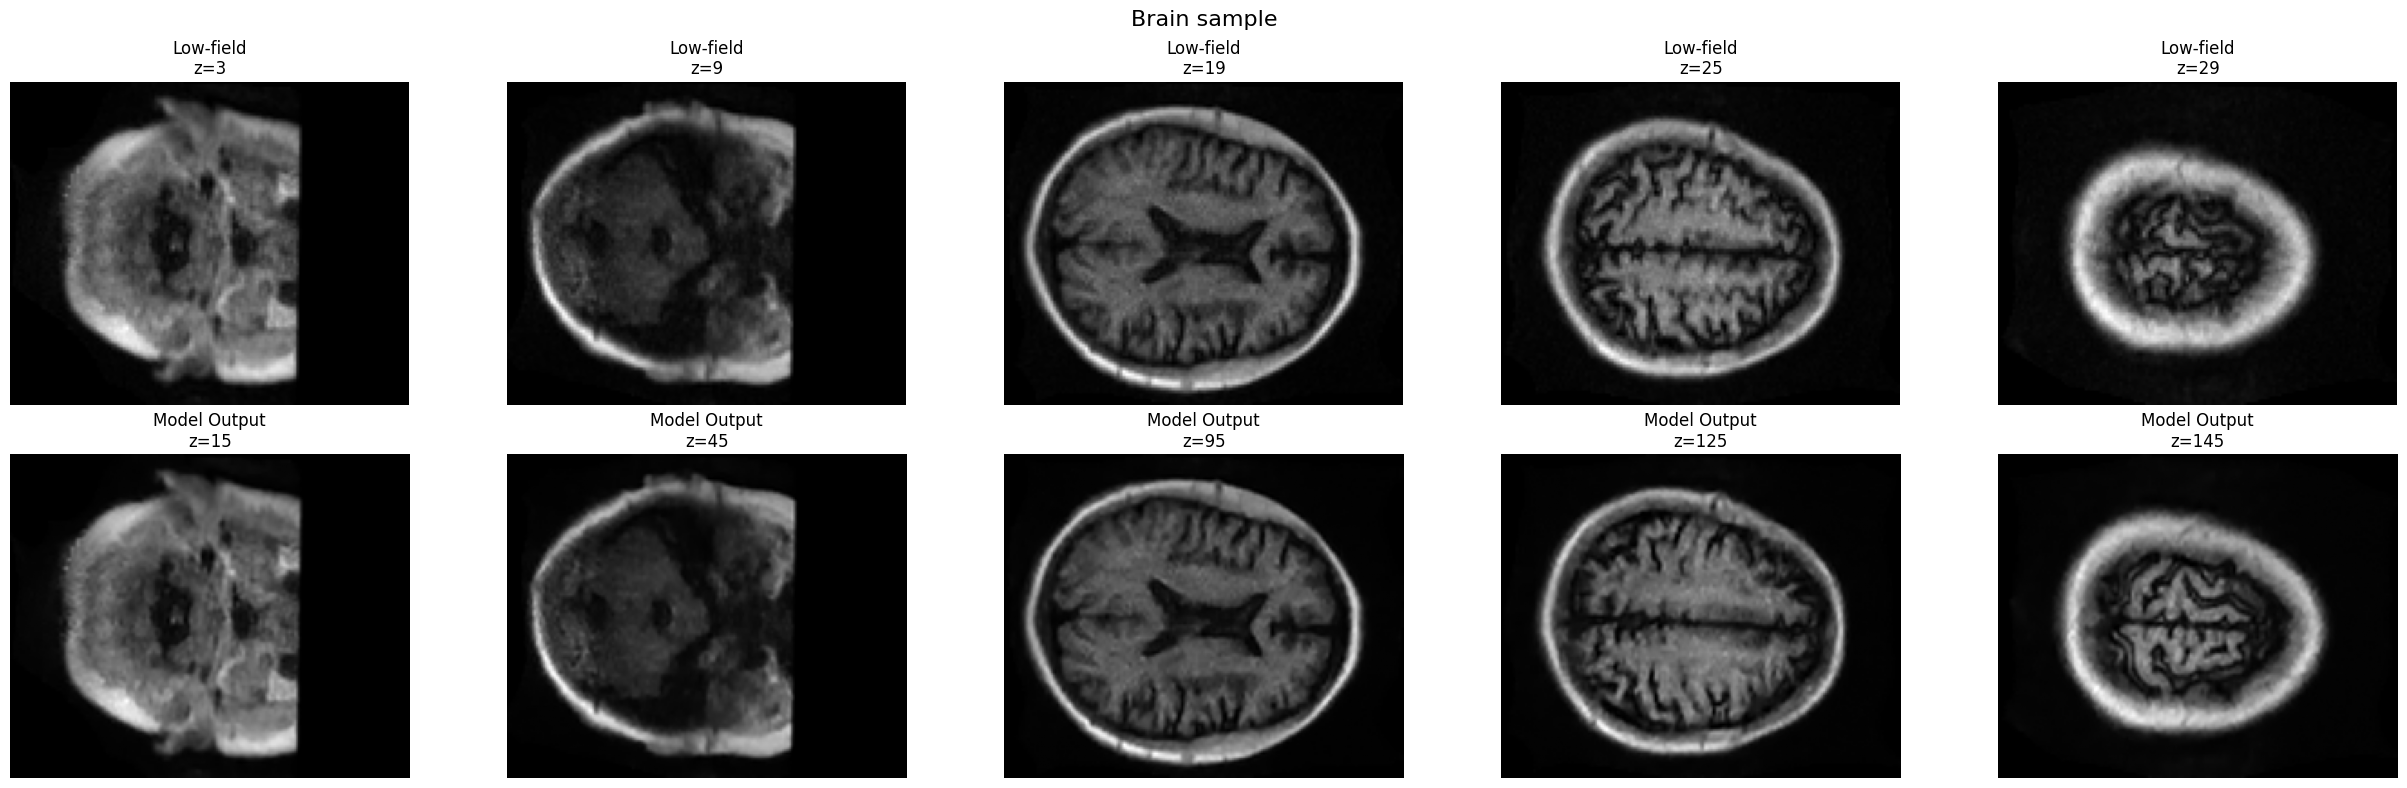

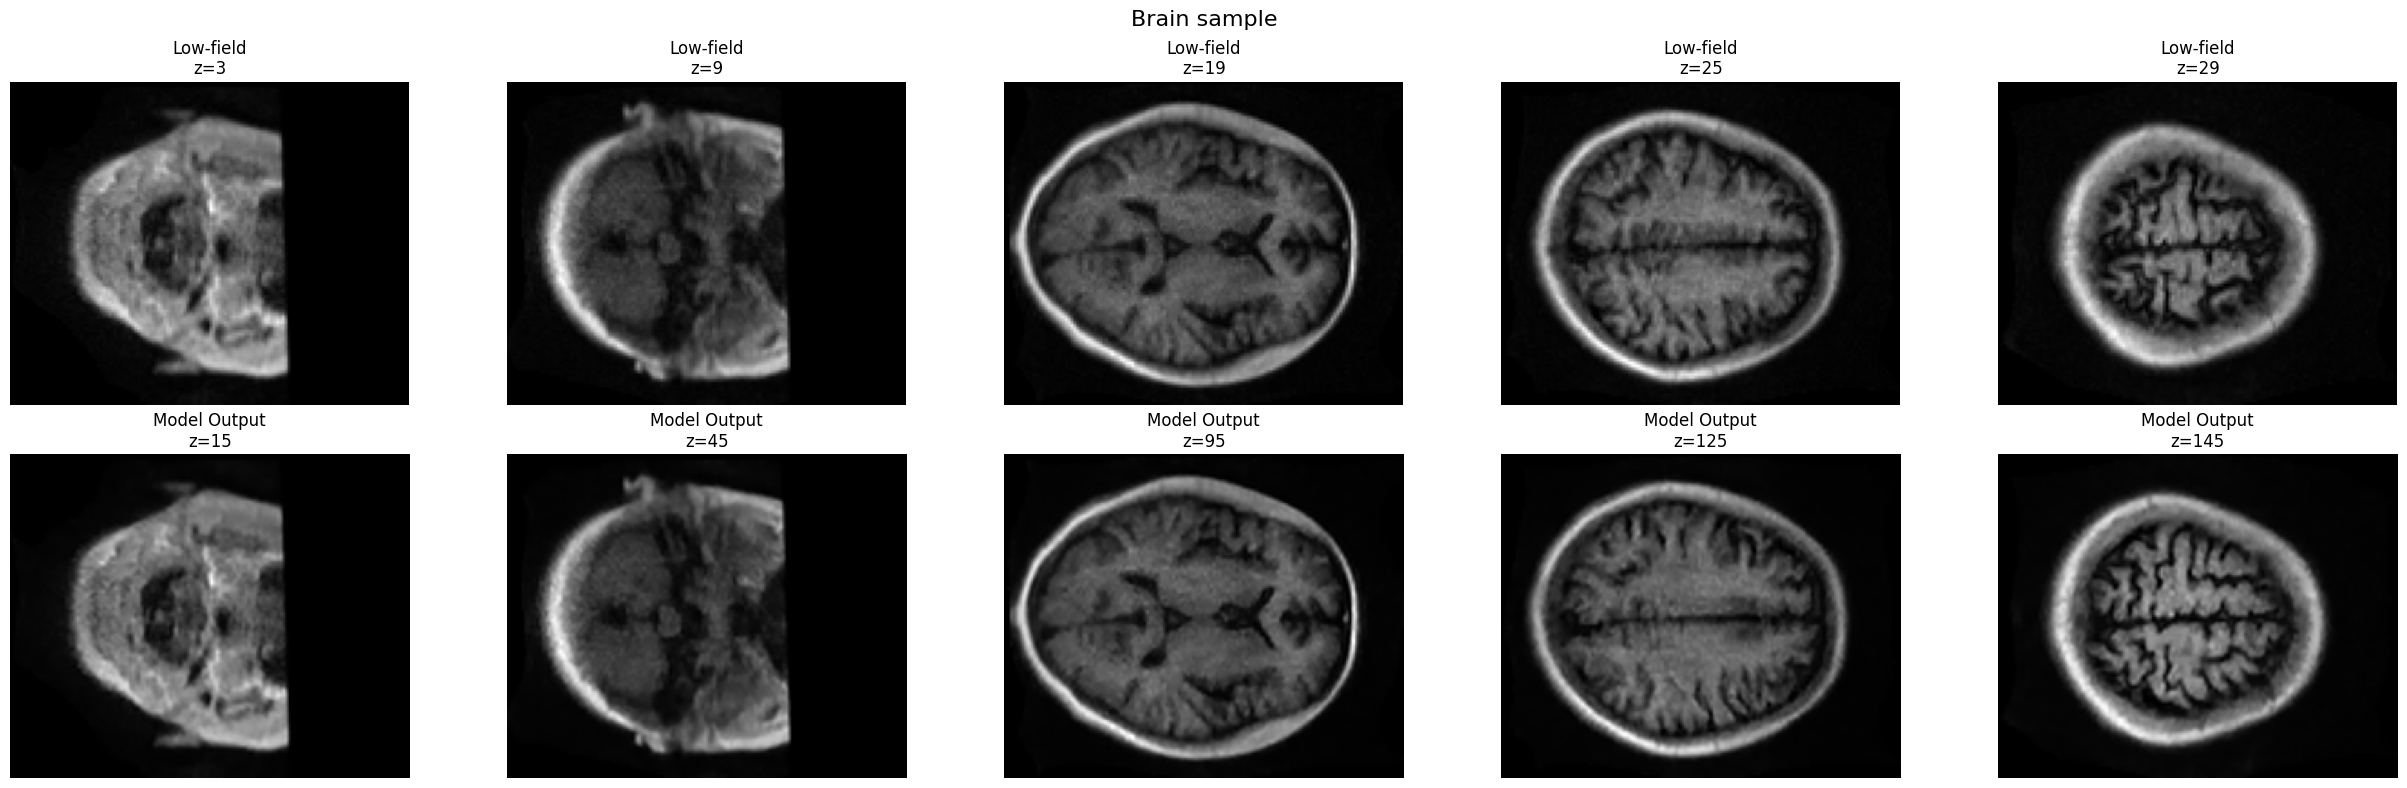

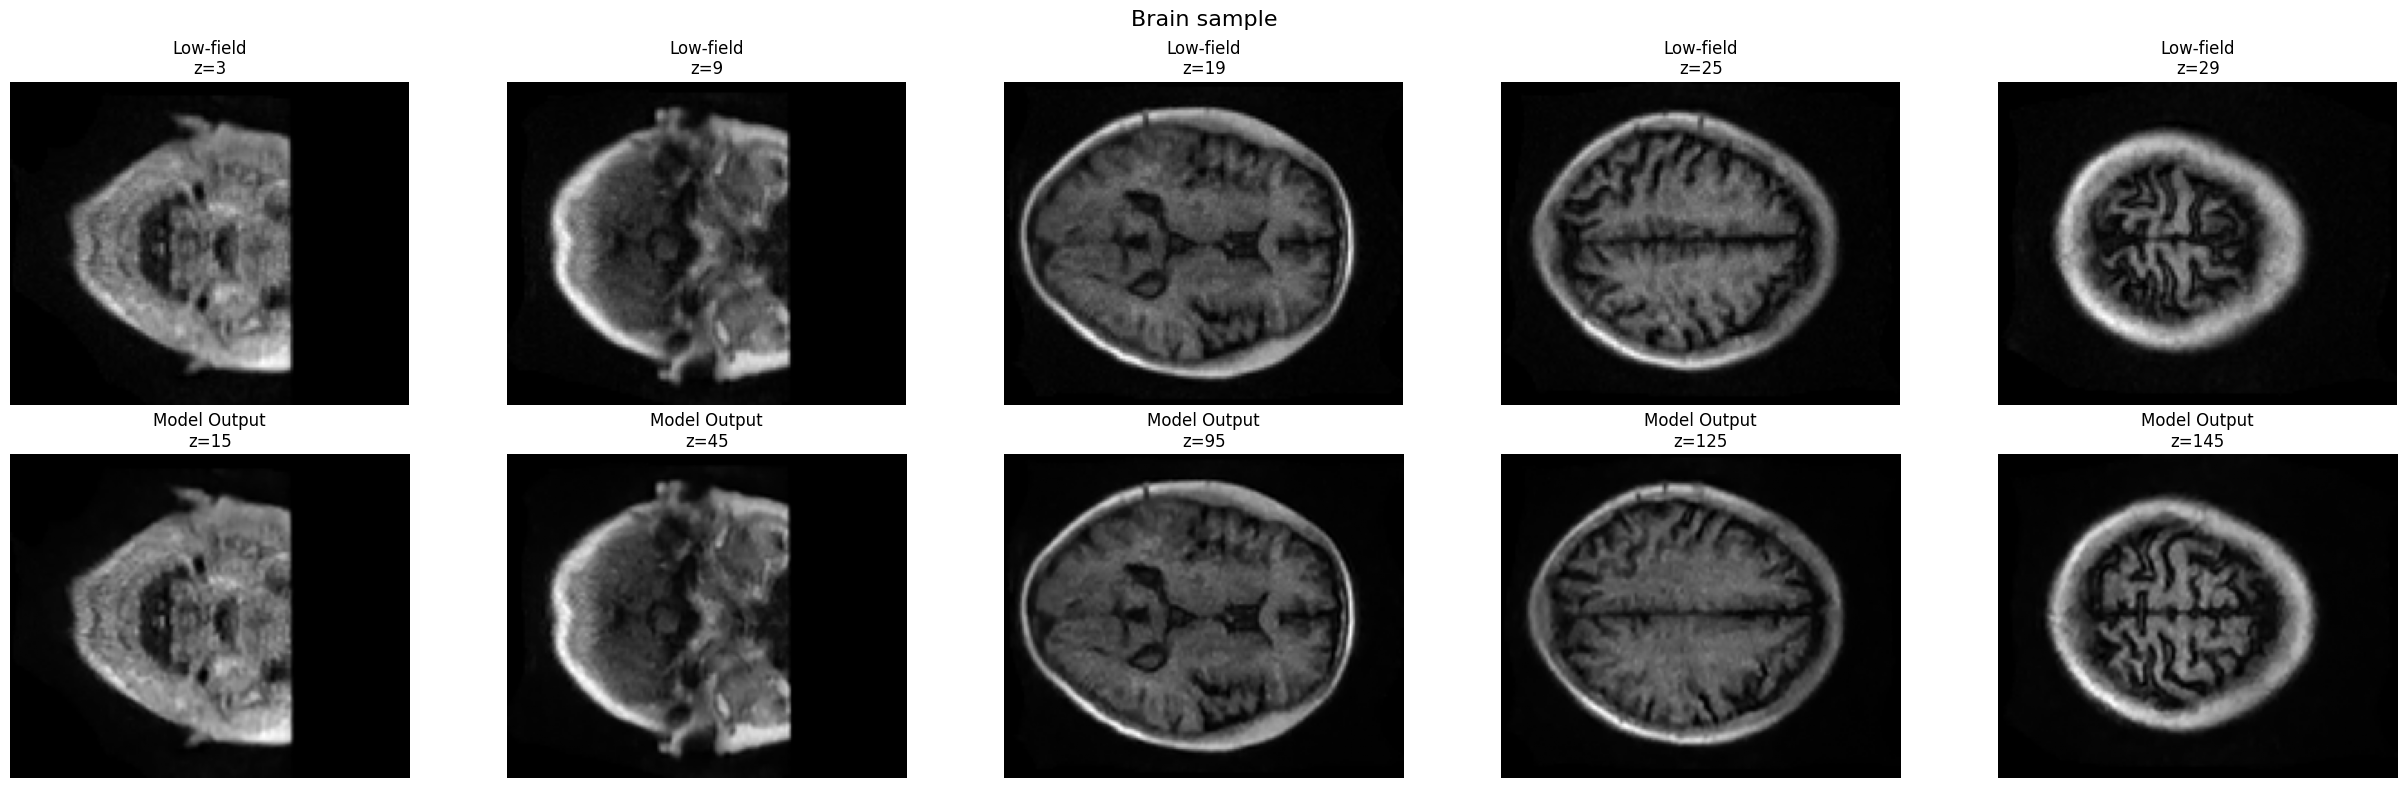

Processing sample_019...
Processing sample_020...
Processing sample_021...
Processing sample_022...
Processing sample_023...

 Submission saved as submission.csv
Total rows: 1000 (should be 1000)


In [26]:

# VISUALIZATION

def plot_fractional_slices_triplet(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(idxs), figsize=(5 * len(idxs), 8))

    for j, z in enumerate(idxs):
        axes[0, j].imshow(low[:, :, z], cmap="gray")
        axes[0, j].set_title(f"Low (z={z})")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, z], cmap="gray")
        axes[1, j].set_title("Model Output")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================
# BASE64 ENCODING
# =========================
def slice_to_base64(slice_2d):
    smin, smax = float(slice_2d.min()), float(slice_2d.max())
    if smax > smin:
        norm = ((slice_2d - smin) / (smax - smin) * 255).astype(np.uint8)
    else:
        norm = np.zeros_like(slice_2d, dtype=np.uint8)

    buf = io.BytesIO()
    np.savez_compressed(buf,
                        slice=norm,
                        shape=slice_2d.shape,
                        min_val=smin,
                        max_val=smax)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

def volume_to_rows(volume, sample_id):
    rows = []
    for z in range(volume.shape[2]):  # now guaranteed 200
        rows.append({
            "row_id": f"{sample_id}_slice_{z:03d}",
            "prediction": slice_to_base64(volume[:, :, z])
        })
    return rows

all_rows = []

nii_files = sorted([
    f for f in os.listdir(LR_NIFTI_DIR)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])

# ---- VISUALIZE SOME SAMPLES ----
def plot_fractional_slices_low_vs_model(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    zp = pred.shape[2]

    low_idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, lz in enumerate(low_idxs):
        pz = int(lz * zp / zl)

        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, pz], cmap="gray")
        axes[1, j].set_title(f"Model Output\nz={pz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

viz_samples = random.sample(nii_files, min(3, len(nii_files)))

for fname in viz_samples:
    sample_id = fname.split("_")[0]
    path = os.path.join(LR_NIFTI_DIR, fname)

    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(model, lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    plot_fractional_slices_low_vs_model(
        low=lr_vol,
        pred=pred_vol,
        brain_id=sample_id,
    )

# ---- CREATE SUBMISSION ----
for fname in nii_files:
    parts = fname.split("_")
    sample_id = f"{parts[0]}_{parts[1]}"
    path = os.path.join(LR_NIFTI_DIR, fname)

    print(f"Processing {sample_id}...")
    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(model, lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    assert pred_vol.shape[2] == TARGET_SLICES

    all_rows.extend(volume_to_rows(pred_vol, sample_id))

df = pd.DataFrame(all_rows)
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n Submission saved as {OUTPUT_CSV}")
print(f"Total rows: {len(df)} (should be {len(nii_files) * TARGET_SLICES})")

In [23]:
!ls /content/data/test/low_field

sample_019_lowfield.nii  sample_021_lowfield.nii  sample_023_lowfield.nii
sample_020_lowfield.nii  sample_022_lowfield.nii
